# Severstal: Steel Defect Detection

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *

## Getting the data

In [2]:
! {sys.executable} -m pip install kaggle --upgrade

     |████████████████████████████████| 61kB 13.0MB/s eta 0:00:01
  Stored in directory: /home/ubuntu/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.2
    Uninstalling kaggle-1.5.2:
      Successfully uninstalled kaggle-1.5.2


In [7]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [8]:
path = Config.data_path()/'severstal-steel-defect-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [9]:
! kaggle competitions download -c severstal-steel-defect-detection -f train.csv -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f train_images.zip -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f test_images.zip -p {path}  
! unzip -q -n {path}/train_images.zip -d {path}/train_images
! unzip -q -n {path}/test_images.zip -d {path}/test_images
! unzip -q -n {path}/train.csv.zip -d {path}

 72%|███████████████████████████▍          | 5.00M/6.91M [00:00<00:00, 43.5MB/s]
100%|██████████████████████████████████████| 6.91M/6.91M [00:00<00:00, 57.2MB/s]
 98%|██████████████████████████████████████▏| 1.14G/1.16G [00:08<00:00, 113MB/s]
100%|███████████████████████████████████████| 1.16G/1.16G [00:08<00:00, 152MB/s]
 93%|██████████████████████████████████████▏  | 120M/129M [00:00<00:00, 126MB/s]
100%|█████████████████████████████████████████| 129M/129M [00:00<00:00, 142MB/s]


In [11]:
! chmod 555 '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train.csv'

## Data Ingestion

In [12]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


# Build SegmentationList

In [13]:
def process_csv(path, csv):
    
    train_df = pd.read_csv(path/csv)
    
    train_df['label'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[-1], axis=1)
    train_df['image_id'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[0], axis=1)

    proc_train_df = train_df.pivot(index='image_id', columns='label', values='EncodedPixels').reset_index(drop=False)

    proc_train_df = proc_train_df.fillna(value=' ')

#     proc_train_df.to_csv('proc_train.csv', index=False)
    
    return proc_train_df

In [14]:
proc_train_df = process_csv(path, 'train.csv')

In [15]:
proc_train_df.head()

label,image_id,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [17]:
! mkdir '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels'

In [18]:
def make_labels_rle(path, train, proc_train_df, labels):
    for index, row in proc_train_df.iterrows():
        save_rle_label_image(path, row, train, labels)

In [19]:
def save_rle_label_image(path, mask_df, train, labels):
    image_id, rles = mask_df[0], mask_df[1:]
    image_fn = re.search('(.*?)\.jpg', image_id).group(1)+'.png'
    shape = open_image(path/train/image_id).shape[-2:]
    final_mask = torch.zeros((1, *shape))
    for k, rle in enumerate(rles):
        if isinstance(rle, str):
            mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
            final_mask += (k+1)*mask
    mask_img = image2np(final_mask.data).astype(np.uint8)
    PIL.Image.fromarray(mask_img).save(path/labels/image_fn, 'png')
    
#     ImageSegment(final_mask).save(path/labels/image_id)

In [20]:
path_img = path/'train_images'

In [21]:
path_lbl = path/'labels'

In [22]:
get_y_fn = lambda x: (path_lbl/f'{x.stem}').with_suffix('.png')

In [23]:
make_labels_rle(path, 'train_images', proc_train_df, path_lbl)

In [24]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/6ac1d05d3.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/f0b2483fa.jpg')]

In [25]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1863eb011.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/62cf0b008.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1c2a39896.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/8bfc35309.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/e6207db1a.png')]

torch.Size([3, 256, 1600])


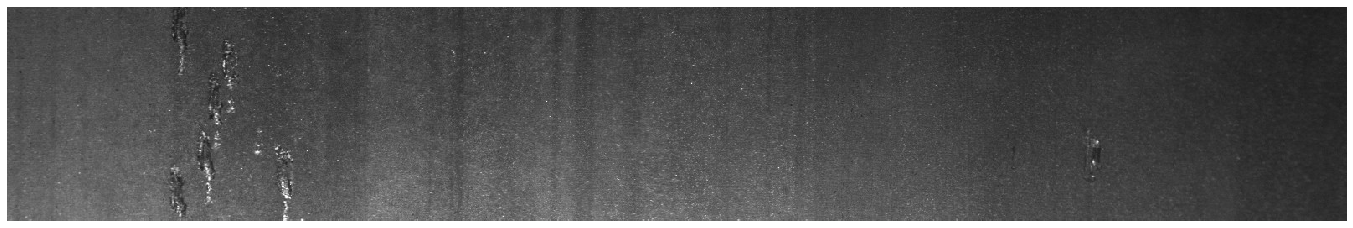

In [26]:
img_f = fnames[3]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(24,24))

{0, 3}


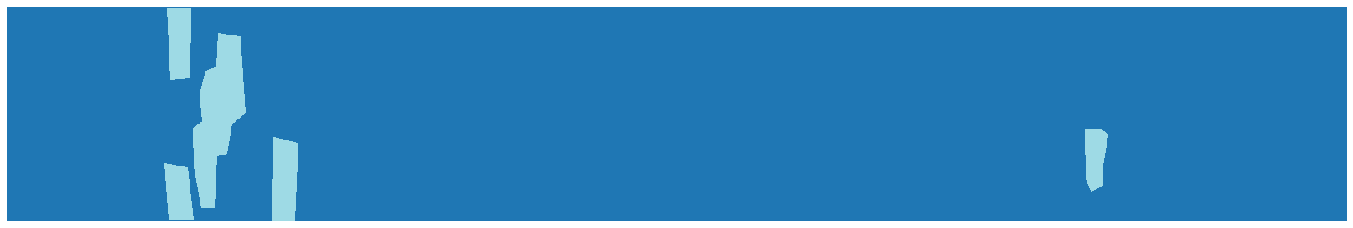

In [27]:
mask = open_mask(get_y_fn(img_f))
print(set(mask.data.numpy().flatten()))
mask.show(figsize=(24,24), alpha=1)

In [49]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 256, 1600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [29]:
codes = [0,1,2,3,4]

In [50]:
from fastai.utils.mem import *
size = src_size//2
print(size)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

[128 800]
using bs=8, have 10572MB of GPU RAM free


In [53]:
size = size//2
print(size)

[ 64 400]


In [33]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(get_y_fn, classes=codes))

In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

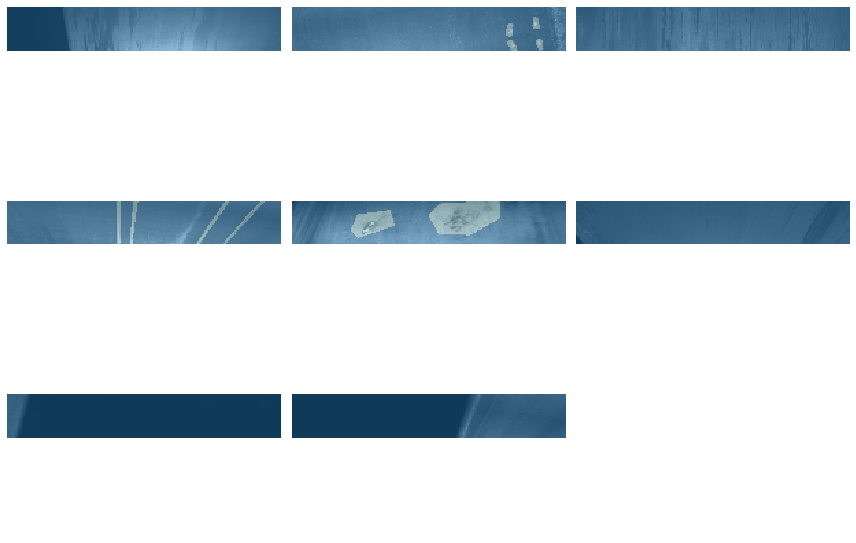

In [35]:
data.show_batch(3, figsize=(12,9))

In [36]:
arch = models.resnet18

In [37]:
from fastai.metrics import dice
learn = unet_learner(data, arch, metrics=[dice])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


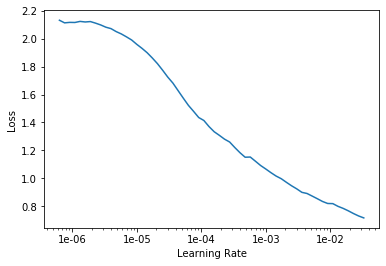

In [38]:
lr_find(learn)
learn.recorder.plot()

In [39]:
lr=1e-04

In [40]:
print(lr)

0.0001


In [41]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.120836,0.105573,0.513727,03:48
1,0.094524,0.091609,0.814645,03:43
2,0.090748,0.083514,1.194012,03:42
3,0.094708,0.084035,0.987881,03:44
4,0.085171,0.072325,1.401402,03:43


In [42]:
learn.save('stage-1-rn18')

...And fine-tune the whole model:

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


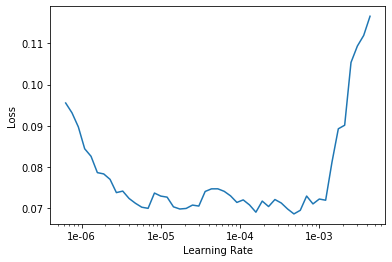

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
# Pick a value just before the slope goes upward, then 10x smaller
lr = 1e-04
print(lr)

0.0001


In [46]:
# LR / 5 or LR / 10 - Discriminate learning
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.076451,0.070916,1.354732,03:54
1,0.081195,0.069432,1.470850,03:57
2,0.076071,0.070064,1.387026,03:56
3,0.080098,0.067003,1.530236,03:56
4,0.074872,0.066339,1.502766,03:56


In [47]:
learn.save('stage-2-rn18')

In [54]:
# size = size*2
print(size)

[ 64 400]


In [57]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 64, 400])

In [58]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


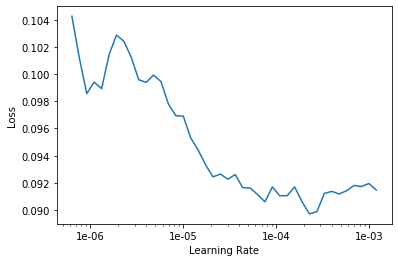

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr=1e-05/5

In [61]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.086889,0.079472,1.557580,07:49
1,0.078923,0.073919,1.706381,07:42
2,0.076980,0.071398,1.748325,07:40
3,0.075141,0.070566,1.775537,07:41
4,0.073912,0.070268,1.776918,07:41


In [62]:
learn.save('stage-1-64-rn18')

In [63]:
learn.unfreeze()

In [64]:
# learn.fit_one_cycle(5, slice(1e-5, lr/5))

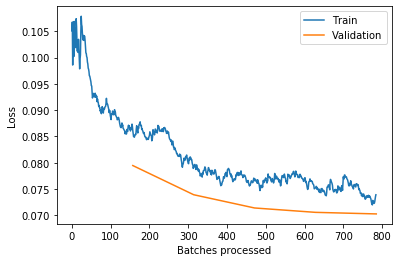

In [65]:
learn.recorder.plot_losses()

In [ ]:
# learn.save('stage-2-256-rn50')

In [73]:
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [74]:
learn.path = path

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [75]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [144]:
# # add test data
# learn.data.test_ds.tfms = []
# learn.data.test_ds.tfms_y = []
# test_imgs = path/'test_images'
# test_data = SegmentationItemList.from_folder(test_imgs)
# learn.data.add_test(test_data)

In [145]:
test_data = ItemList.from_folder(path/'test_images')

In [146]:
size

array([ 64, 400])

In [118]:
# tfms = get_transforms()

In [143]:
# learn.data.add_test(test_data, tfms=None)

In [141]:
# test_data =(SegmentationItemList.from_folder(test_imgs))

In [147]:
# learn = load_learner(path, test=test_data, tfm_y=False)
# preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)